# Pseudo Double Source Plane Lenses (PDSPL) Forecast
### Author: Paras Sharma

This notebook simulates pseudo double source plane lenses and mainly tries to answer the following questions:

Given the number of expected lenses to be of order 100'000, how near-identical are pairs of lenses to look like, such that they can be used as a defacto double source plane lenses?

1. Perform a forecast of lenses with SLSim
2. Assess how close nearest-pairs of lenses are look-alike and how much scatter they introduce in their estimated mass.
3. Perform a forecast how pseudo double source plane lenses can constrain cosmology pretending them to be double source plane lenses with increased measurement uncertainties. You can use hierArc to run the forecast.


In [2]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
import numpy as np
import corner
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.lens import Lens
from slsim.image_simulation import lens_image, rgb_image_from_image_list
from slsim.Util.param_util import gaussian_psf
# import standard python modules
import copy
import matplotlib.patches as mpatches
from itertools import combinations

%matplotlib inline

# import lenstronomy and hierArc modules
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

from hierarc.Likelihood.LensLikelihood.double_source_plane import (
    beta_double_source_plane,
    beta2theta_e_ratio,
)


/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SL Research/codes/repos/self/slsim/slsim/Plots/lens_plots.py:5: UserWarning: If you want to simulate images with Roman filters, please install the galsim module.
Note that this module is not supported on Windows
  from slsim.roman_image_simulation import simulate_roman_image


## Generate population of sources and (potential) deflectors

In [3]:
# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo = cosmo_param.cosmo(kwargs_cosmo_true)

# define a sky area
sky_area = Quantity(value=1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# Generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=sky_area, filters=None, cosmo=cosmo
)

# Initiate deflector population class.
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo,
    sky_area=sky_area,
)

# Initiate source population class.
source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    catalog_type="skypy",
)

# make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area,
)

# make lensplot class for extracting rgb images
gg_plot = LensingPlots(gg_lens_pop, num_pix=100, coadd_years=10)

print(f"LensPop initialized. Potential deflectors: {gg_lens_pop.deflector_number} ; Potential sources: {gg_lens_pop.source_number}");

/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SL Research/codes/repos/self/slsim/slsim/Deflectors/all_lens_galaxies.py:54: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SL Research/codes/repos/self/slsim/slsim/Deflectors/all_lens_galaxies.py:57: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


LensPop initialized. Potential deflectors: 350906 ; Potential sources: 473694


## Select Near-identical lenses using a criterion

In [28]:
# kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}
kwargs_lens_cut = {}
selected_lenses = gg_lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cut,
)
print(f"Number of selected lenses: {len(selected_lenses)}")

Number of selected lenses: 3382


In [29]:
# make pairs of deflector and source galaxies and find the measured ratios of the Einstein radius
lens_pairings = combinations(
    selected_lenses, 2
)  # all possible pairs of lenses
lens_pairings = list(lens_pairings)

pairing_parameters = {
    "lens_pairings": [],
    "z_D1": [],
    "z_D2": [],
    "z_S1": [],
    "z_S2": [],
    "theta_E1": [],
    "theta_E2": [],
    "theta_E_ratio": [],
    "theta_E1_virtual": [], # virtual Einstein radius of lens1 for source2
    "theta_E2_virtual": [], # virtual Einstein radius of lens2 for source1
    "theta_E1_by_theta_E2_virtual": [], # ratio of virtual Einstein radii
    "theta_E1_virtual_by_theta_E2": [], # ratio of virtual Einstein radii
    "sigma_v_D1": [], # velocity dispersion of deflector 1
    "sigma_v_D2": [], # velocity dispersion of deflector 2
    "beta_DSPL_D1": [], # beta double source plane i.e., ratio of distances, assuming D1
    "beta_DSPL_D2": [], # beta double source plane i.e., ratio of distances, assuming D2
    "delta_z_D": [], # difference in redshift of deflector 1 and 2
    "delta_sigma_v_D": [], # difference in velocity dispersions
    "abs_delta_z_D": [], # absolute difference in redshift of deflector 1 and 2
    "abs_delta_sigma_v_D": [], # absolute difference in velocity dispersions
}

for lens_pair in lens_pairings:
    lens1 = lens_pair[0]
    lens2 = lens_pair[1]

    source1 = lens1.source(index = 0)
    source2 = lens2.source(index = 0)

    deflector1 = lens1.deflector
    deflector2 = lens2.deflector

    # get the deflector and source redshifts
    z_D1 = lens1.deflector_redshift
    z_D2 = lens2.deflector_redshift
    z_S1 = source1.redshift
    z_S2 = source2.redshift

    # get the Einstein radii
    theta_E1 = lens1._einstein_radius(source1)
    theta_E2 = lens2._einstein_radius(source2)

    # get the velocity dispersions
    sigma_v_D1 = deflector1.velocity_dispersion()
    sigma_v_D2 = deflector2.velocity_dispersion()

    # calculate the ratio of the Einstein radii
    theta_E_ratio = theta_E1 / theta_E2

    # calculate the virtual Einstein radii
    theta_E1_virtual = lens2._einstein_radius(source1) # virtual Einstein radius of lens2 for source1
    theta_E2_virtual = lens1._einstein_radius(source2) # virtual Einstein radius of lens1 for source2

    # calculate the ratio of the virtual Einstein radii
    theta_E1_by_theta_E2_virtual = theta_E1 / theta_E2_virtual
    theta_E1_virtual_by_theta_E2 = theta_E1_virtual / theta_E2

    # calculate the beta double source plane
    if z_D1 < np.min([z_S1, z_S2]) and z_D2 < np.min([z_S1, z_S2]):
        beta_DSPL_D1 = beta_double_source_plane(
            z_D1, z_S1, z_S2, cosmo
        )
        beta_DSPL_D2 = beta_double_source_plane(
            z_D2, z_S1, z_S2, cosmo
        )
    elif z_D1 < np.min([z_S1, z_S2]) and z_D2 > np.max([z_S1, z_S2]):
        beta_DSPL_D1 = beta_double_source_plane(
            z_D1, z_S1, z_S2, cosmo
        )
        beta_DSPL_D2 = np.nan
    elif z_D1 > np.max([z_S1, z_S2]) and z_D2 < np.min([z_S1, z_S2]):
        beta_DSPL_D1 = np.nan
        beta_DSPL_D2 = beta_double_source_plane(
            z_D2, z_S1, z_S2, cosmo
        )
    else:
        beta_DSPL_D1 = np.nan
        beta_DSPL_D2 = np.nan

    # calculate the difference in redshift and velocity dispersion
    delta_z_D = z_D1 - z_D2
    delta_sigma_v_D = sigma_v_D1 - sigma_v_D2
    abs_delta_z_D = np.abs(delta_z_D)
    abs_delta_sigma_v_D = np.abs(delta_sigma_v_D)

    # append the values to the pairing_parameters dictionary
    pairing_parameters["lens_pairings"].append(lens_pair)
    pairing_parameters["z_D1"].append(z_D1)
    pairing_parameters["z_D2"].append(z_D2)
    pairing_parameters["z_S1"].append(z_S1)
    pairing_parameters["z_S2"].append(z_S2)
    pairing_parameters["theta_E1"].append(theta_E1)
    pairing_parameters["theta_E2"].append(theta_E2)
    pairing_parameters["theta_E_ratio"].append(theta_E_ratio)
    pairing_parameters["theta_E1_virtual"].append(theta_E1_virtual)
    pairing_parameters["theta_E2_virtual"].append(theta_E2_virtual)
    pairing_parameters["theta_E1_by_theta_E2_virtual"].append(
        theta_E1_by_theta_E2_virtual
    )
    pairing_parameters["theta_E1_virtual_by_theta_E2"].append(
        theta_E1_virtual_by_theta_E2
    )
    pairing_parameters["sigma_v_D1"].append(sigma_v_D1)
    pairing_parameters["sigma_v_D2"].append(sigma_v_D2)
    pairing_parameters["beta_DSPL_D1"].append(beta_DSPL_D1)
    pairing_parameters["beta_DSPL_D2"].append(beta_DSPL_D2)
    pairing_parameters["delta_z_D"].append(delta_z_D)
    pairing_parameters["delta_sigma_v_D"].append(delta_sigma_v_D)
    pairing_parameters["abs_delta_z_D"].append(abs_delta_z_D)
    pairing_parameters["abs_delta_sigma_v_D"].append(abs_delta_sigma_v_D)
# convert the pairing_parameters dictionary to a numpy array
pairing_parameters = {
    key: np.array(value) for key, value in pairing_parameters.items()
}

/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_57818/3925738166.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  theta_E1_by_theta_E2_virtual = theta_E1_virtual / theta_E2_virtual


Text(0.5, 0.95, 'Initial Pairing Parameters')

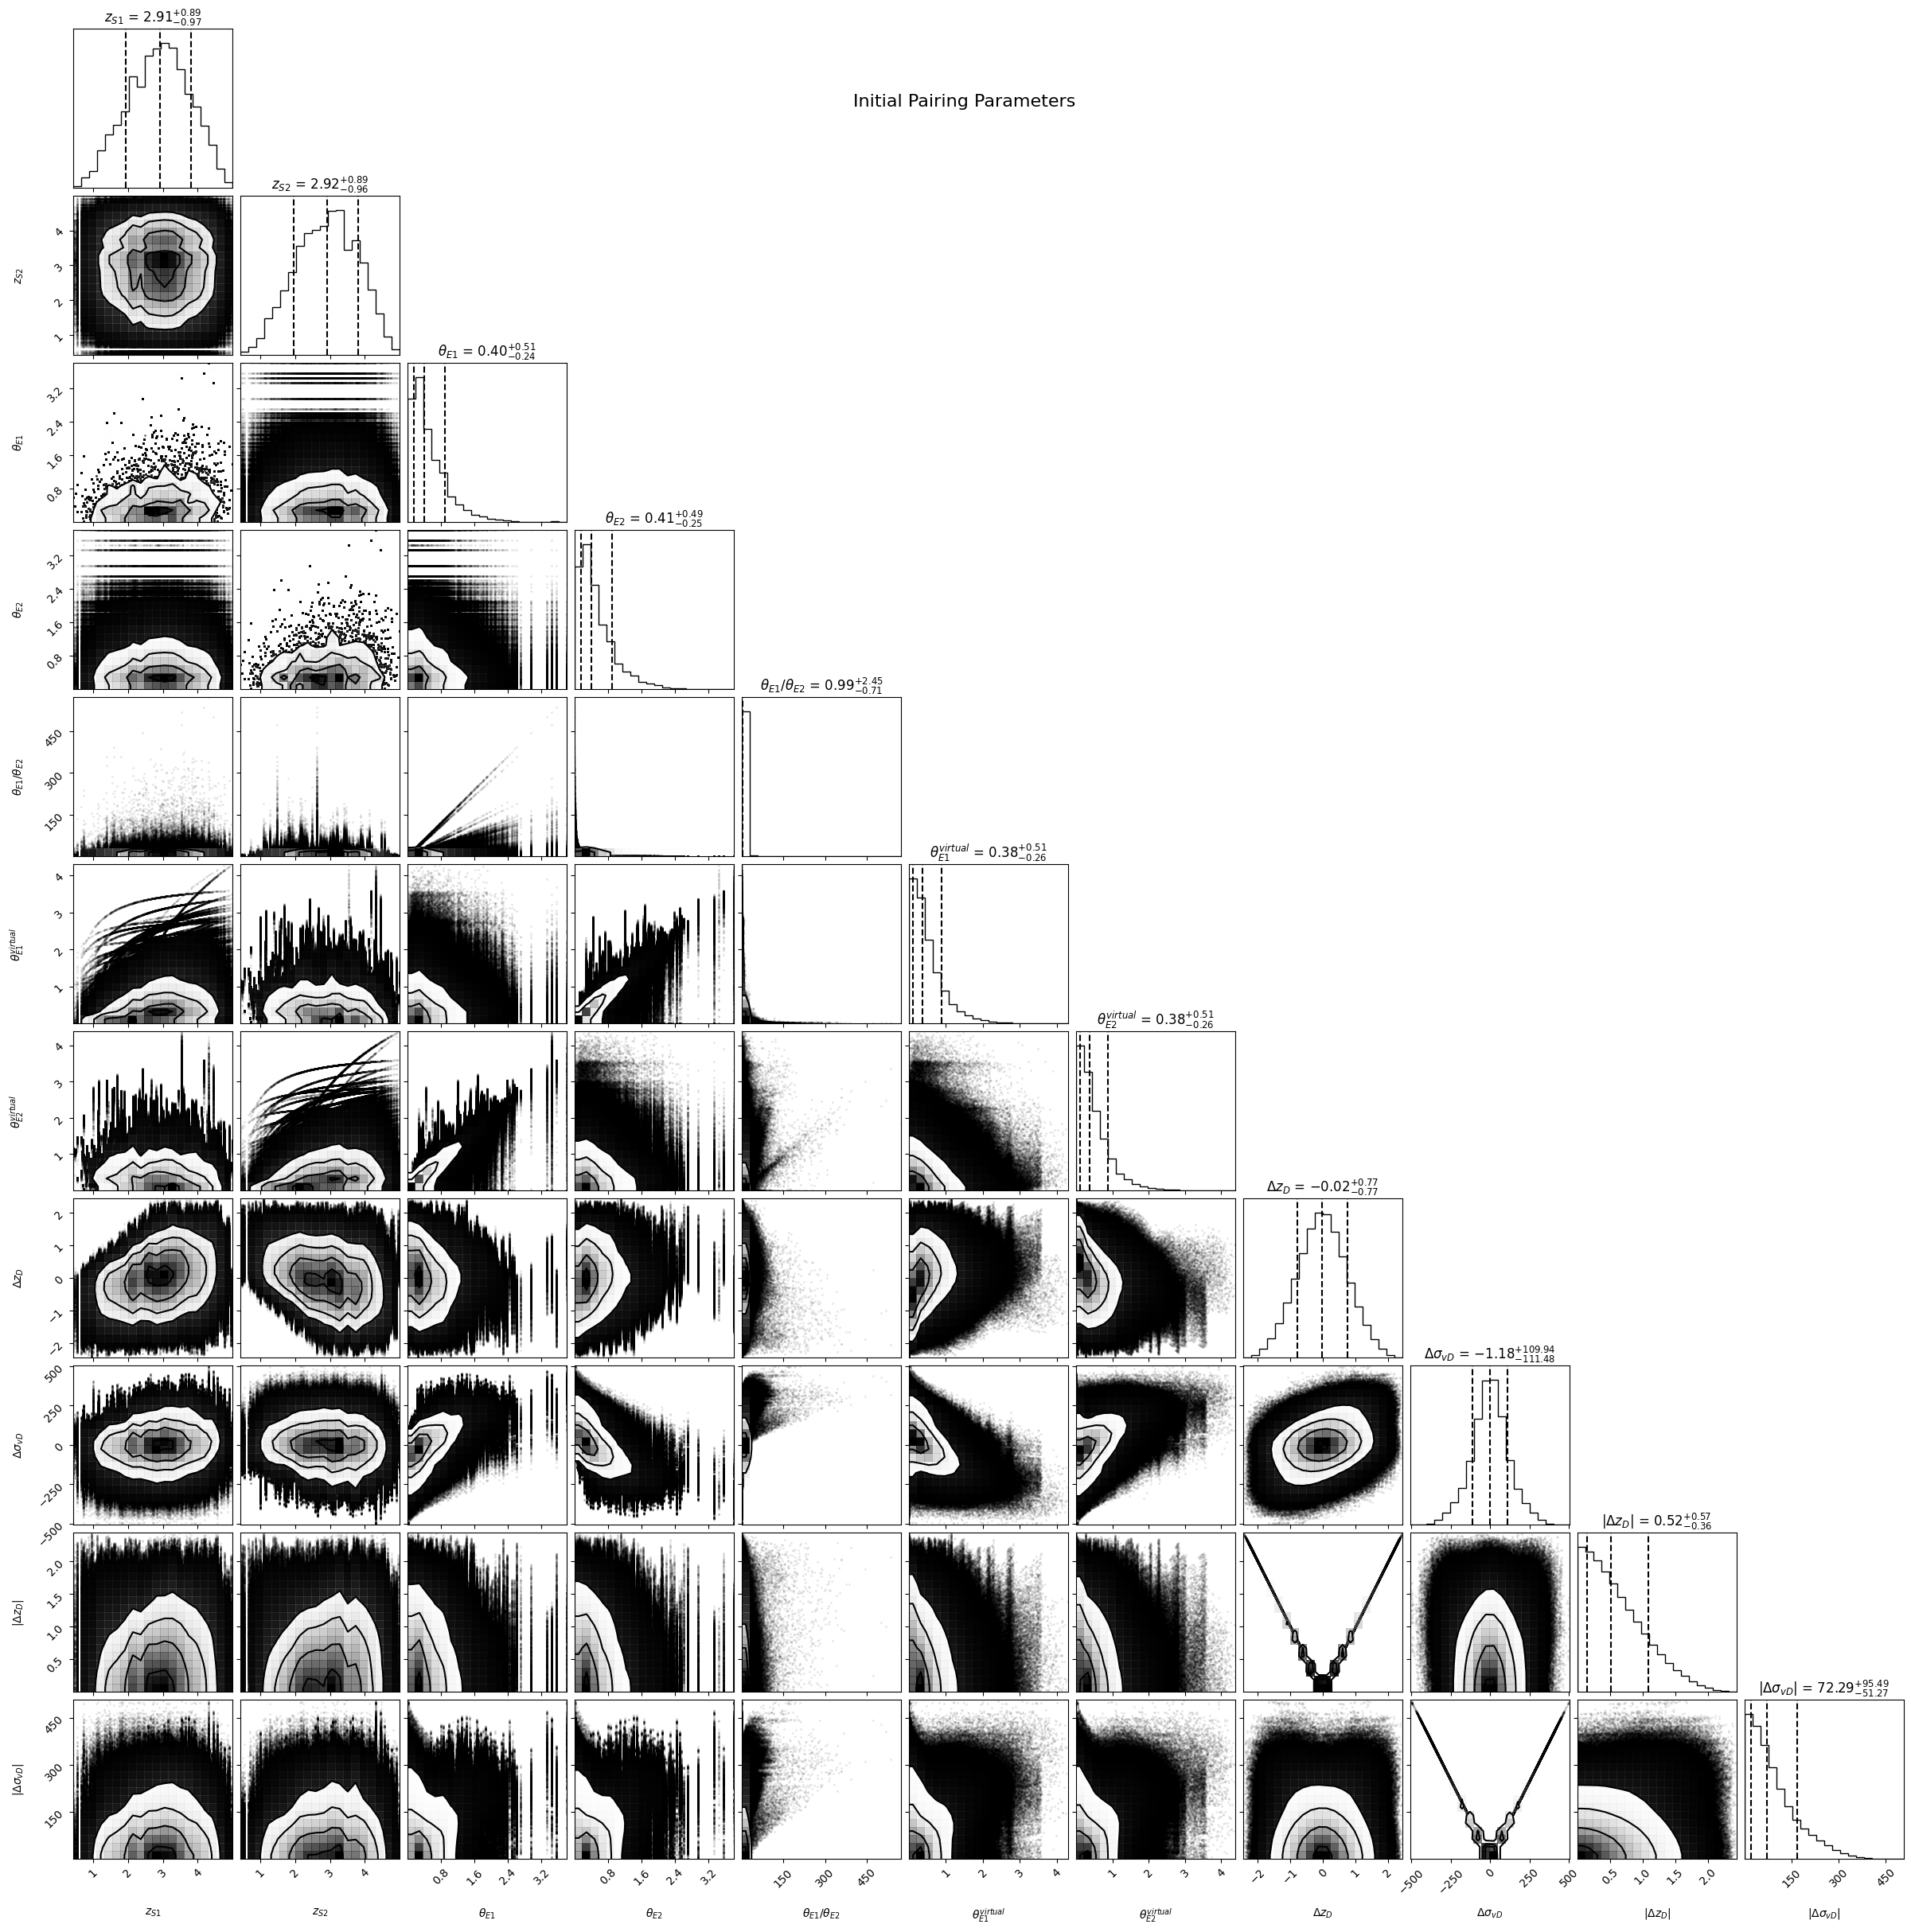

In [30]:
# make a corner plot for all the parameters

# Define the exact order of parameters we want to plot:
keys = [
    "z_S1", "z_S2",
    "theta_E1", "theta_E2", "theta_E_ratio",
    "theta_E1_virtual", "theta_E2_virtual",
    # "beta_DSPL_D1", "beta_DSPL_D2",
    "delta_z_D", "delta_sigma_v_D",
    "abs_delta_z_D", "abs_delta_sigma_v_D",
]

latex_labels = {
    "z_S1": r"$z_{S1}$",
    "z_S2": r"$z_{S2}$",
    "theta_E1": r"$\theta_{E1}$",
    "theta_E2": r"$\theta_{E2}$",
    "theta_E_ratio": r"$\theta_{E1}/\theta_{E2}$",
    "theta_E1_virtual": r"$\theta_{E1}^{virtual}$",
    "theta_E2_virtual": r"$\theta_{E2}^{virtual}$",
    # "beta_DSPL_D1": r"$\beta_{DSPL D1}$",
    # "beta_DSPL_D2": r"$\beta_{DSPL D2}$",
    "delta_z_D": r"$\Delta z_D$",
    "delta_sigma_v_D": r"$\Delta \sigma_{vD}$",
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$",
}

# Stack into an (n_samples, n_keys) array:
data = np.column_stack([pairing_parameters[k] for k in keys])

# Now call corner with the array:
fig = corner.corner(
    data,
    labels=[latex_labels[k] for k in keys],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
)
fig.suptitle(
    "Initial Pairing Parameters",
    fontsize=16,
    y=0.95,
)

Text(0.5, 0.95, 'Filtered Pairing Parameters (Delta z_D < 0.01, Delta sigma_v_D < 10)')

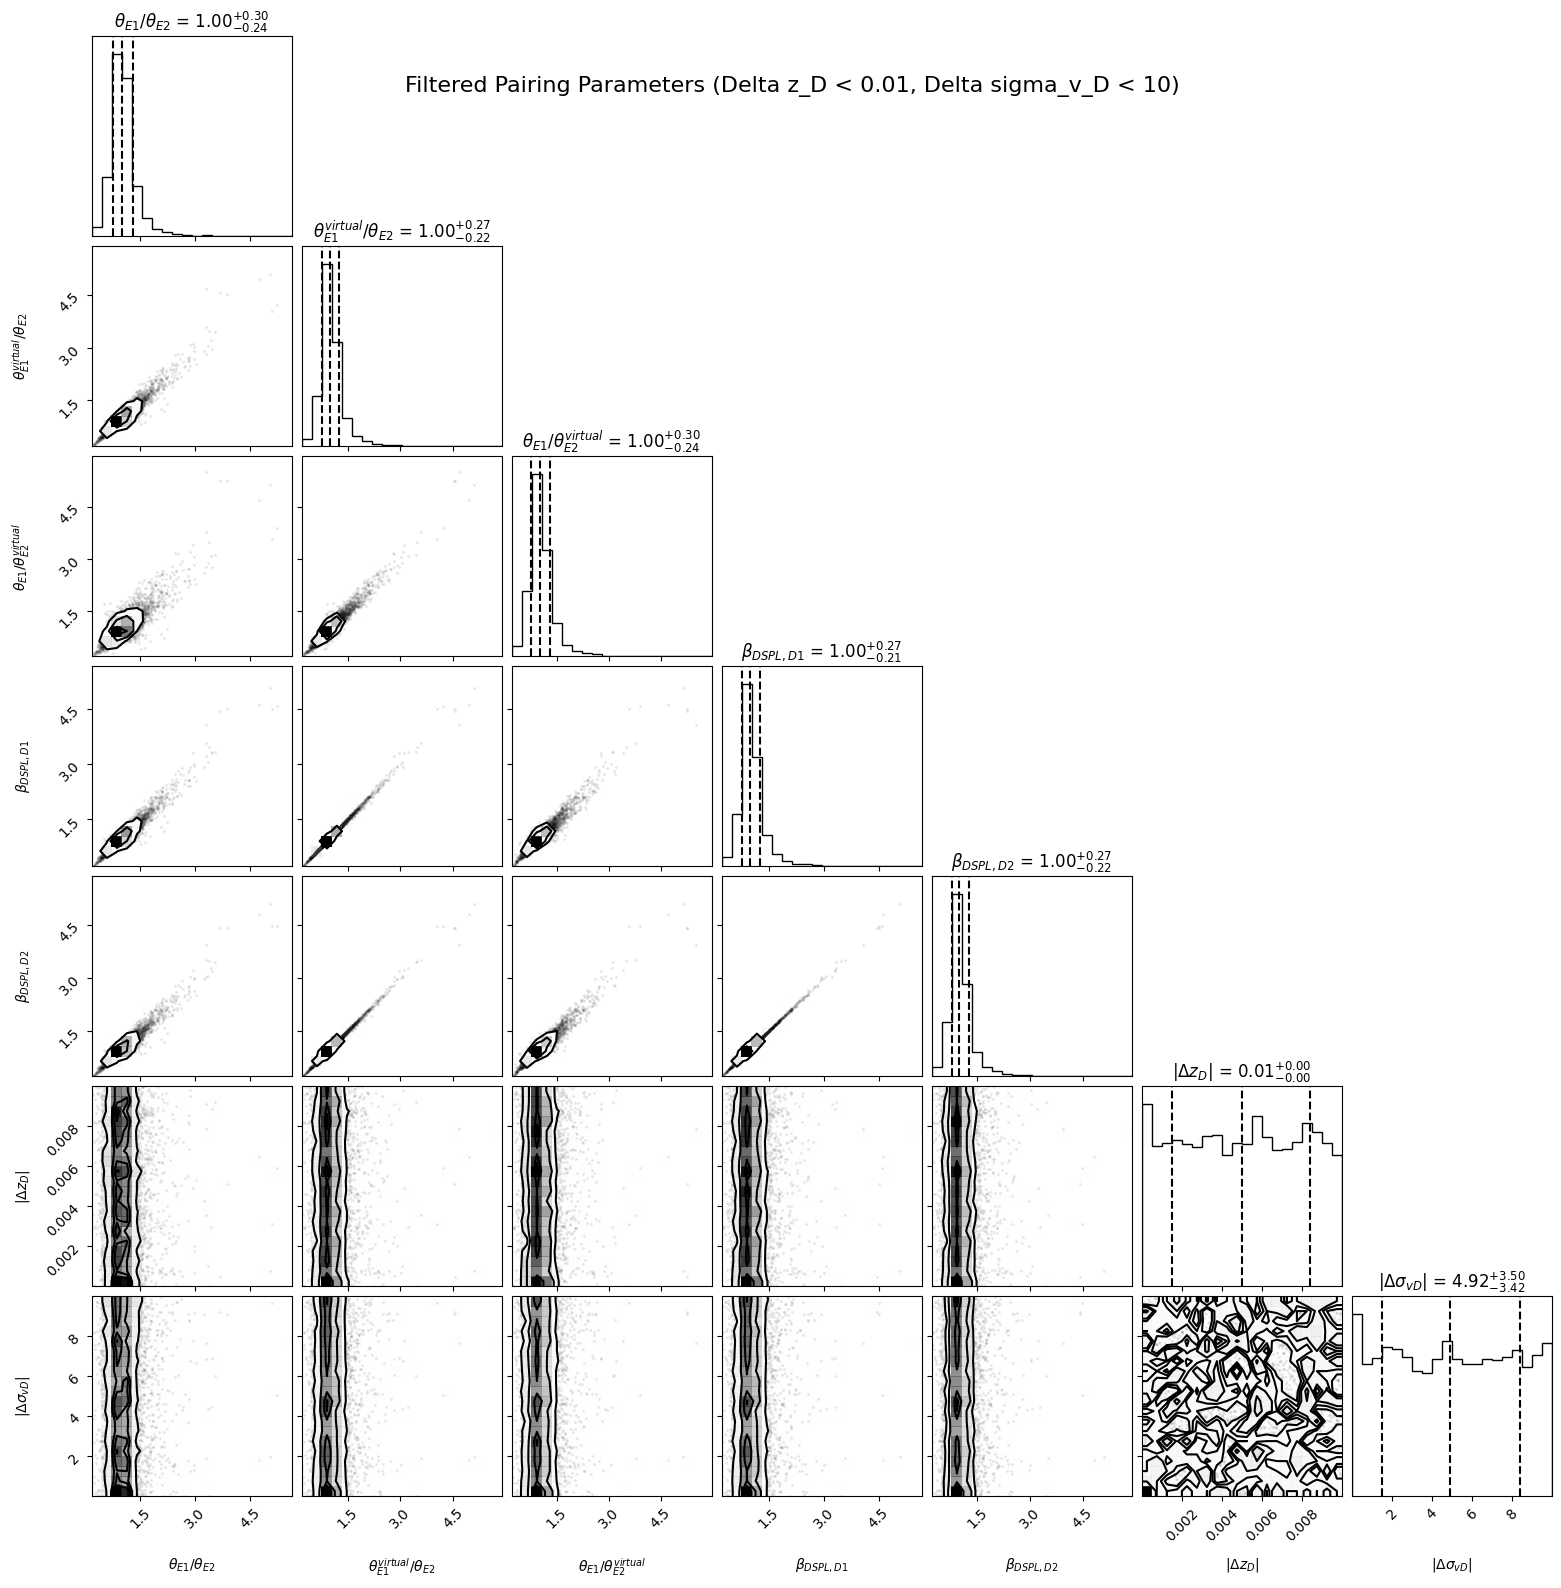

In [31]:
# limit the pairs to those with small delta_z_D and delta_sigma_v_D
delta_z_D_limit = 0.01
delta_sigma_v_D_limit = 10
mask = (
    (pairing_parameters["abs_delta_z_D"] < delta_z_D_limit)
    & (pairing_parameters["abs_delta_sigma_v_D"] < delta_sigma_v_D_limit)
)
filtered_pairing_parameters = {
    key: value[mask] for key, value in pairing_parameters.items()
}

# this time only plot the filtered parameters
keys = [
    "theta_E_ratio",
    "theta_E1_virtual_by_theta_E2",
    "theta_E1_by_theta_E2_virtual",
    "beta_DSPL_D1", "beta_DSPL_D2",
    "abs_delta_z_D", "abs_delta_sigma_v_D",
]

latex_labels = {
    "theta_E_ratio": r"$\theta_{E1}/\theta_{E2}$",
    "theta_E1_virtual_by_theta_E2": r"$\theta_{E1}^{virtual}/\theta_{E2}$",
    "theta_E1_by_theta_E2_virtual": r"$\theta_{E1}/\theta_{E2}^{virtual}$",
    "beta_DSPL_D1": r"$\beta_{DSPL, D1}$",
    "beta_DSPL_D2": r"$\beta_{DSPL, D2}$",
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$",
}

# Stack into an (n_samples, n_keys) array:
data = np.column_stack([filtered_pairing_parameters[k] for k in keys])

# Now call corner with the array:
fig = corner.corner(
    data,
    labels=[latex_labels[k] for k in keys],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
);
fig.suptitle(
    f"Filtered Pairing Parameters (Delta z_D < {delta_z_D_limit}, Delta sigma_v_D < {delta_sigma_v_D_limit})",
    fontsize=16,
    y=0.95,
)

### Likelihood function

$$ \mathcal{L} = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left(-\frac{(x_i - \mu_i))^2}{2\sigma_i^2}\right) $$

where $\theta$ is the parameter of interest, $x_i$ is the observed data, $\mu_i$ is the expected value, and $\sigma_i$ is the standard deviation of the measurement error.

$$x_i = \frac{\tilde{\theta}_{E1}}{\tilde{\theta}_{E2}}$$

where $\tilde{\theta}_{E1}$ and $\tilde{\theta}_{E2}$ are measured Einstein radii of the two lenses with deflectors at nearly identical redshifts $z_d$ and sources at $z_1$ and $z_2$.

$$\mu_i = \frac{\theta_{E1}}{\theta_{E2}}\left[\gamma_{pl}, \lambda_{MST}, \beta(z_d, z_1, z_2, \Omega_m, w)\right]$$

where $\gamma_{pl}$ is the power-law slope of the mass profile, $\lambda_{MST}$ is the mass-sheet transformation parameter, and $\beta(z_d, z_1, z_2)$ is the DSPL parameter from distances ratios.

$$\sigma_i^2 = \sigma^2\left(\frac{\tilde{\theta}_{E1}}{\tilde{\theta}_{E2}}\right)+ \sigma_{scatter}^2\left(\frac{{\theta}_{E1}}{{\theta}_{E2}}\right)$$

$$\sigma_{scatter}^2\left(\frac{{\theta}_{E1}}{{\theta}_{E2}}\right) = $$

For a power-law mass profile, the Einstein radius is given by (https://ned.ipac.caltech.edu/level5/Sept14/Courteau/Courteau7.html):
$$\theta_E(z_s)
=\Biggl[
  K(\gamma_{pl})\,
  \frac{\sigma_{\rm ap}^2}{c^2}\;
  \frac{D_{\rm ls}(z_{\rm l},\,z_s)}{D_{\rm s}(z_s)}
\Biggr]^{\!1/(\gamma_{pl}-1)}
$$

$$
K(\gamma_{pl})
=\frac{(3-\gamma_{pl})}{2\,\sqrt\pi}\,
\frac{\Gamma\!\bigl(\tfrac{\gamma_{pl}}{2}\bigr)}
     {\Gamma\!\bigl(\tfrac{\gamma_{pl}-1}{2}\bigr)}
$$

and the corresponding beta is 
$$
\beta_{\gamma_{pl}}
=\frac{\theta_E(z_{s2})}{\theta_E(z_{s1})}
=\left[
  \frac{\,D_{\rm ls}(z_{\rm l},\,z_{s2})/D_{\rm s}(z_{s2})\,}
       {\,D_{\rm ls}(z_{\rm l},\,z_{s1})/D_{\rm s}(z_{s1})\,}
\right]^{\!1/(\gamma_{pl}-1)}
$$

In [ ]:
def _log_likelihood(
    theta_E_ratio, # observed Einstein radius ratio
    gamma_pl, # power-law slope
    lambda_mst, # mass sheet parameter
    beta_DSPL_D1, # beta double source plane for deflector 1
    beta_DSPL_D2, # beta double source plane for deflector 2
    sigma_theta_E_ratio, # uncertainty in the observed Einstein radius ratio
    simga_scatter = 0, # uncertainty from the model #TODO: this needs to be updated!
    normalized = True, # whether to normalize the likelihood
):
    """
    Calculate the log likelihood of the observed Einstein radius ratio given the model parameters.
    """
    beta_dsp_mean = np.nanmean([beta_DSPL_D1, beta_DSPL_D2])

    # calculate the expected Einstein radius ratio
    theta_E_ratio_model = beta2theta_e_ratio(
        beta_dsp_mean, gamma_pl, lambda_mst
    )

    # calculate the full uncertainty
    sigma_full = np.sqrt(
        sigma_theta_E_ratio ** 2 + simga_scatter ** 2
    )

    # calculate the log likelihood
    log_likelihood = -0.5 * ((theta_E_ratio - theta_E_ratio_model) / sigma_full) ** 2
    if normalized:
        log_likelihood -= np.log(sigma_full * np.sqrt(2 * np.pi))

    return log_likelihood

## Forecast settings

Here we describe the redshift distribution, precision on Einstein radii ratios of an anticipated sample


In [ ]:



# =====================================
# Settings for pupulation of DSP
# =====================================

# number of double source plane lenses
num_dspl = 87

sigma_beta = 0.01  # relative precision on Einstein radius ratio
gamma_pl_mean = 2.05
gamma_pl_sigma = 0.05

lambda_mst_mean = 1
lambda_mst_sigma = 0.05


def draw_lens(lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma):
    """
    draw the likelihood object of a double source plane lens
    """
    z_lens = np.random.uniform(low=0.2, high=0.5)
    z_source1 = np.random.uniform(low=z_lens + 0.2, high=1.5)
    z_source2 = np.random.uniform(low=z_source1, high=3)
    beta = beta_double_source_plane(z_lens, z_source1, z_source2, cosmo)
    # TODO: translate to measured Einstein radius ratio
    lambda_mst = np.random.normal(lambda_mst_mean, lambda_mst_sigma)
    gamma_pl = np.random.normal(gamma_pl_mean, gamma_pl_sigma)
    beta_transformed = beta2theta_e_ratio(
        beta_dsp=beta, gamma_pl=gamma_pl, lambda_mst=lambda_mst
    )
    beta_measured = beta_transformed + np.random.normal(
        loc=0, scale=sigma_beta * beta_transformed
    )
    kwargs_likelihood = {
        "z_lens": z_lens,
        "z_source": z_source1,
        "z_source2": z_source2,
        "beta_dspl": beta_measured,
        "sigma_beta_dspl": sigma_beta * beta,
        "likelihood_type": "DSPL",
    }
    return kwargs_likelihood


kwargs_dspl_list = []

for i in range(num_dspl):
    kwargs_dspl_list.append(
        draw_lens(lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma)
    )